# Plotting notebook for qualitative example

In [54]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

from pathlib import Path
import sys

sys.path.append("/data/performance_estimation")

from classification.load_model_and_config import get_config_data_model_for_eval
from evaluation.inference_utils import open_results_if_exists

config, data_modules, models, output_dirs = get_config_data_model_for_eval(
    "configs/general/scratch/resnet18_scratch.yml", "wilds_camelyon"
)

output_dir = Path(output_dirs[0])

results = open_results_if_exists(output_dir / "val.pickle")
ood_results = open_results_if_exists(output_dir / "ood_test.pickle")

Global seed set to 11
/data/miniconda3/envs/latest_dl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'train_transform_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform_module'])`.
  rank_zero_warn(
/data/miniconda3/envs/latest_dl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'val_transform_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['val_transform_module'])`.
  rank_zero_warn(
/data/miniconda3/envs/latest_dl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'train_transform_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparamet

In [55]:
tsne = TSNE(init="pca")
x2d = tsne.fit_transform(np.concatenate([results["feats"], ood_results["feats"]]))
x2d_val = x2d[: results["feats"].shape[0]]
x2d_ood = x2d[results["feats"].shape[0] :]

/data/miniconda3/envs/latest_dl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/miniconda3/envs/latest_dl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


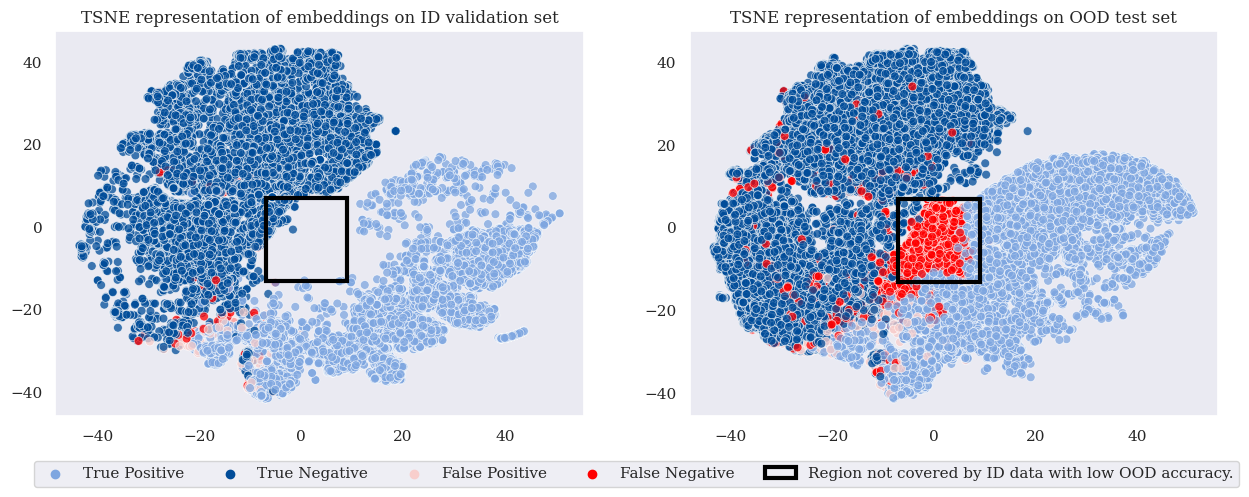

In [58]:
sns.set_theme(style="dark")
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.sans-serif"] = "Times"
combined_style = np.asarray(
    [
        {
            (True, True): "True Positive",
            (False, True): "False Negative",
            (False, False): "True Negative",
            (True, False): "False Positive",
        }[x]
        for x in zip((results["predictions"]).numpy().astype(bool), results["targets"].numpy().astype(bool))
    ]
)

combined_style_ood = np.asarray(
    [
        {
            (True, True): "True Positive",
            (False, True): "False Negative",
            (False, False): "True Negative",
            (True, False): "False Positive",
        }[x]
        for x in zip((ood_results["predictions"]).numpy().astype(bool), ood_results["targets"].numpy().astype(bool))
    ]
)

combined_palette = {
    "True Positive": "#7EA6E0",
    "False Positive": "#F8CECC",
    "True Negative": "#004C99",
    "False Negative": "#FF0000",
}

rng = np.random.default_rng(33)
idx_val = rng.permutation(x2d_val.shape[0])
idx_ood = rng.permutation(x2d_ood.shape[0])

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(
    x=x2d_val[idx_val, 0],
    y=x2d_val[idx_val, 1],
    hue=combined_style[idx_val],
    ax=ax[0],
    palette=combined_palette,
    s=40,
    markers=".",
    alpha=0.75,
)
sns.scatterplot(
    x=x2d_ood[idx_ood, 0],
    y=x2d_ood[idx_ood, 1],
    hue=combined_style_ood[idx_ood],
    ax=ax[1],
    palette=combined_palette,
    markers=".",
    s=40,
    alpha=0.75,
)
left, bottom, width, height = (-7, -13, 16, 20)
rect = mpatches.Rectangle(
    (left, bottom),
    width,
    height,
    fill=False,
    color="black",
    linewidth=3,
    label="Region not covered by ID data with low OOD accuracy.",
)
ax[0].add_patch(rect)
rect = mpatches.Rectangle((left, bottom), width, height, fill=False, color="black", linewidth=3)
ax[1].add_patch(rect)
ax[0].set_title("TSNE representation of embeddings on ID validation set")
ax[1].set_title("TSNE representation of embeddings on OOD test set")
ax[0].legend(ncol=5, bbox_to_anchor=(1.10, -0.15), loc="center")
ax[1].legend().set_visible(False)
f.savefig("tsne_example.pdf", bbox_inches="tight")